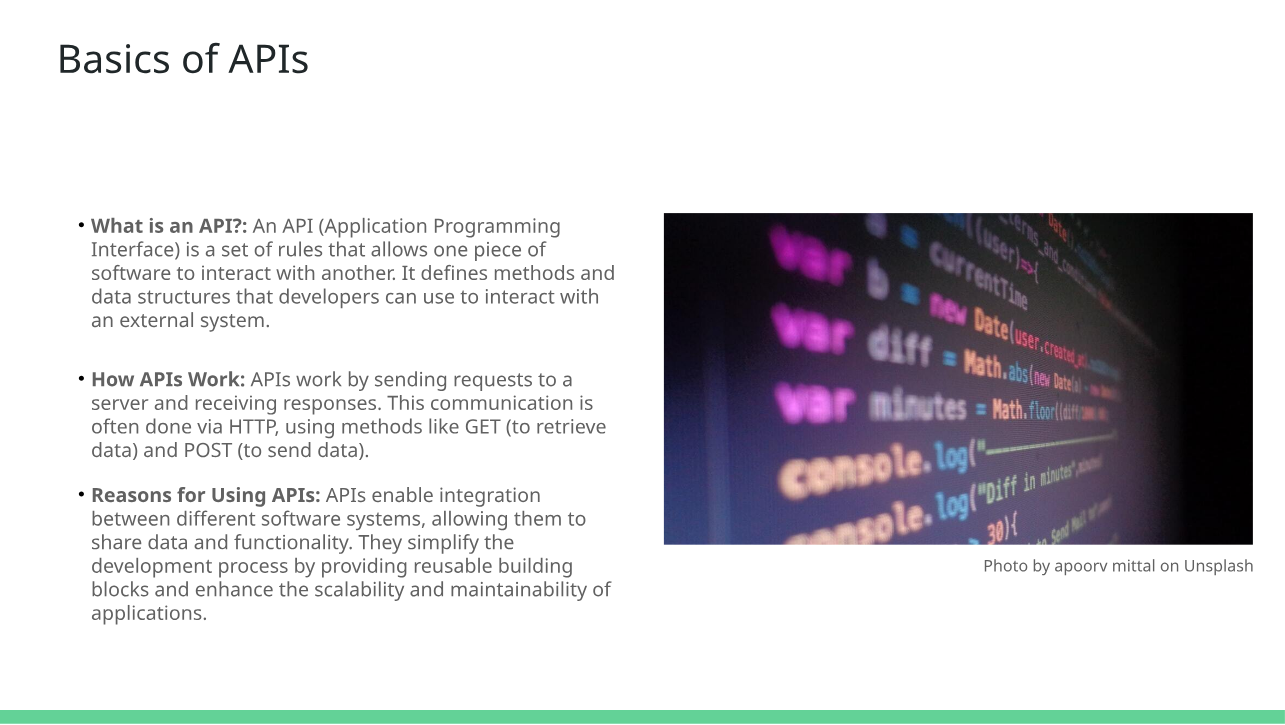

In [18]:
%pip install requests pandas pandasdmx pytz matplotlib ipywidgets tqdm aiohttp chardet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries and set up logging
import asyncio
import aiohttp
import pandas as pd
import pandasdmx as sdmx
from datetime import datetime
import pytz
import os
import json
import glob
import logging
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import pickle

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

C:\Users\M D\AppData\Roaming\Python\Python39\site-packages\pandasdmx\remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


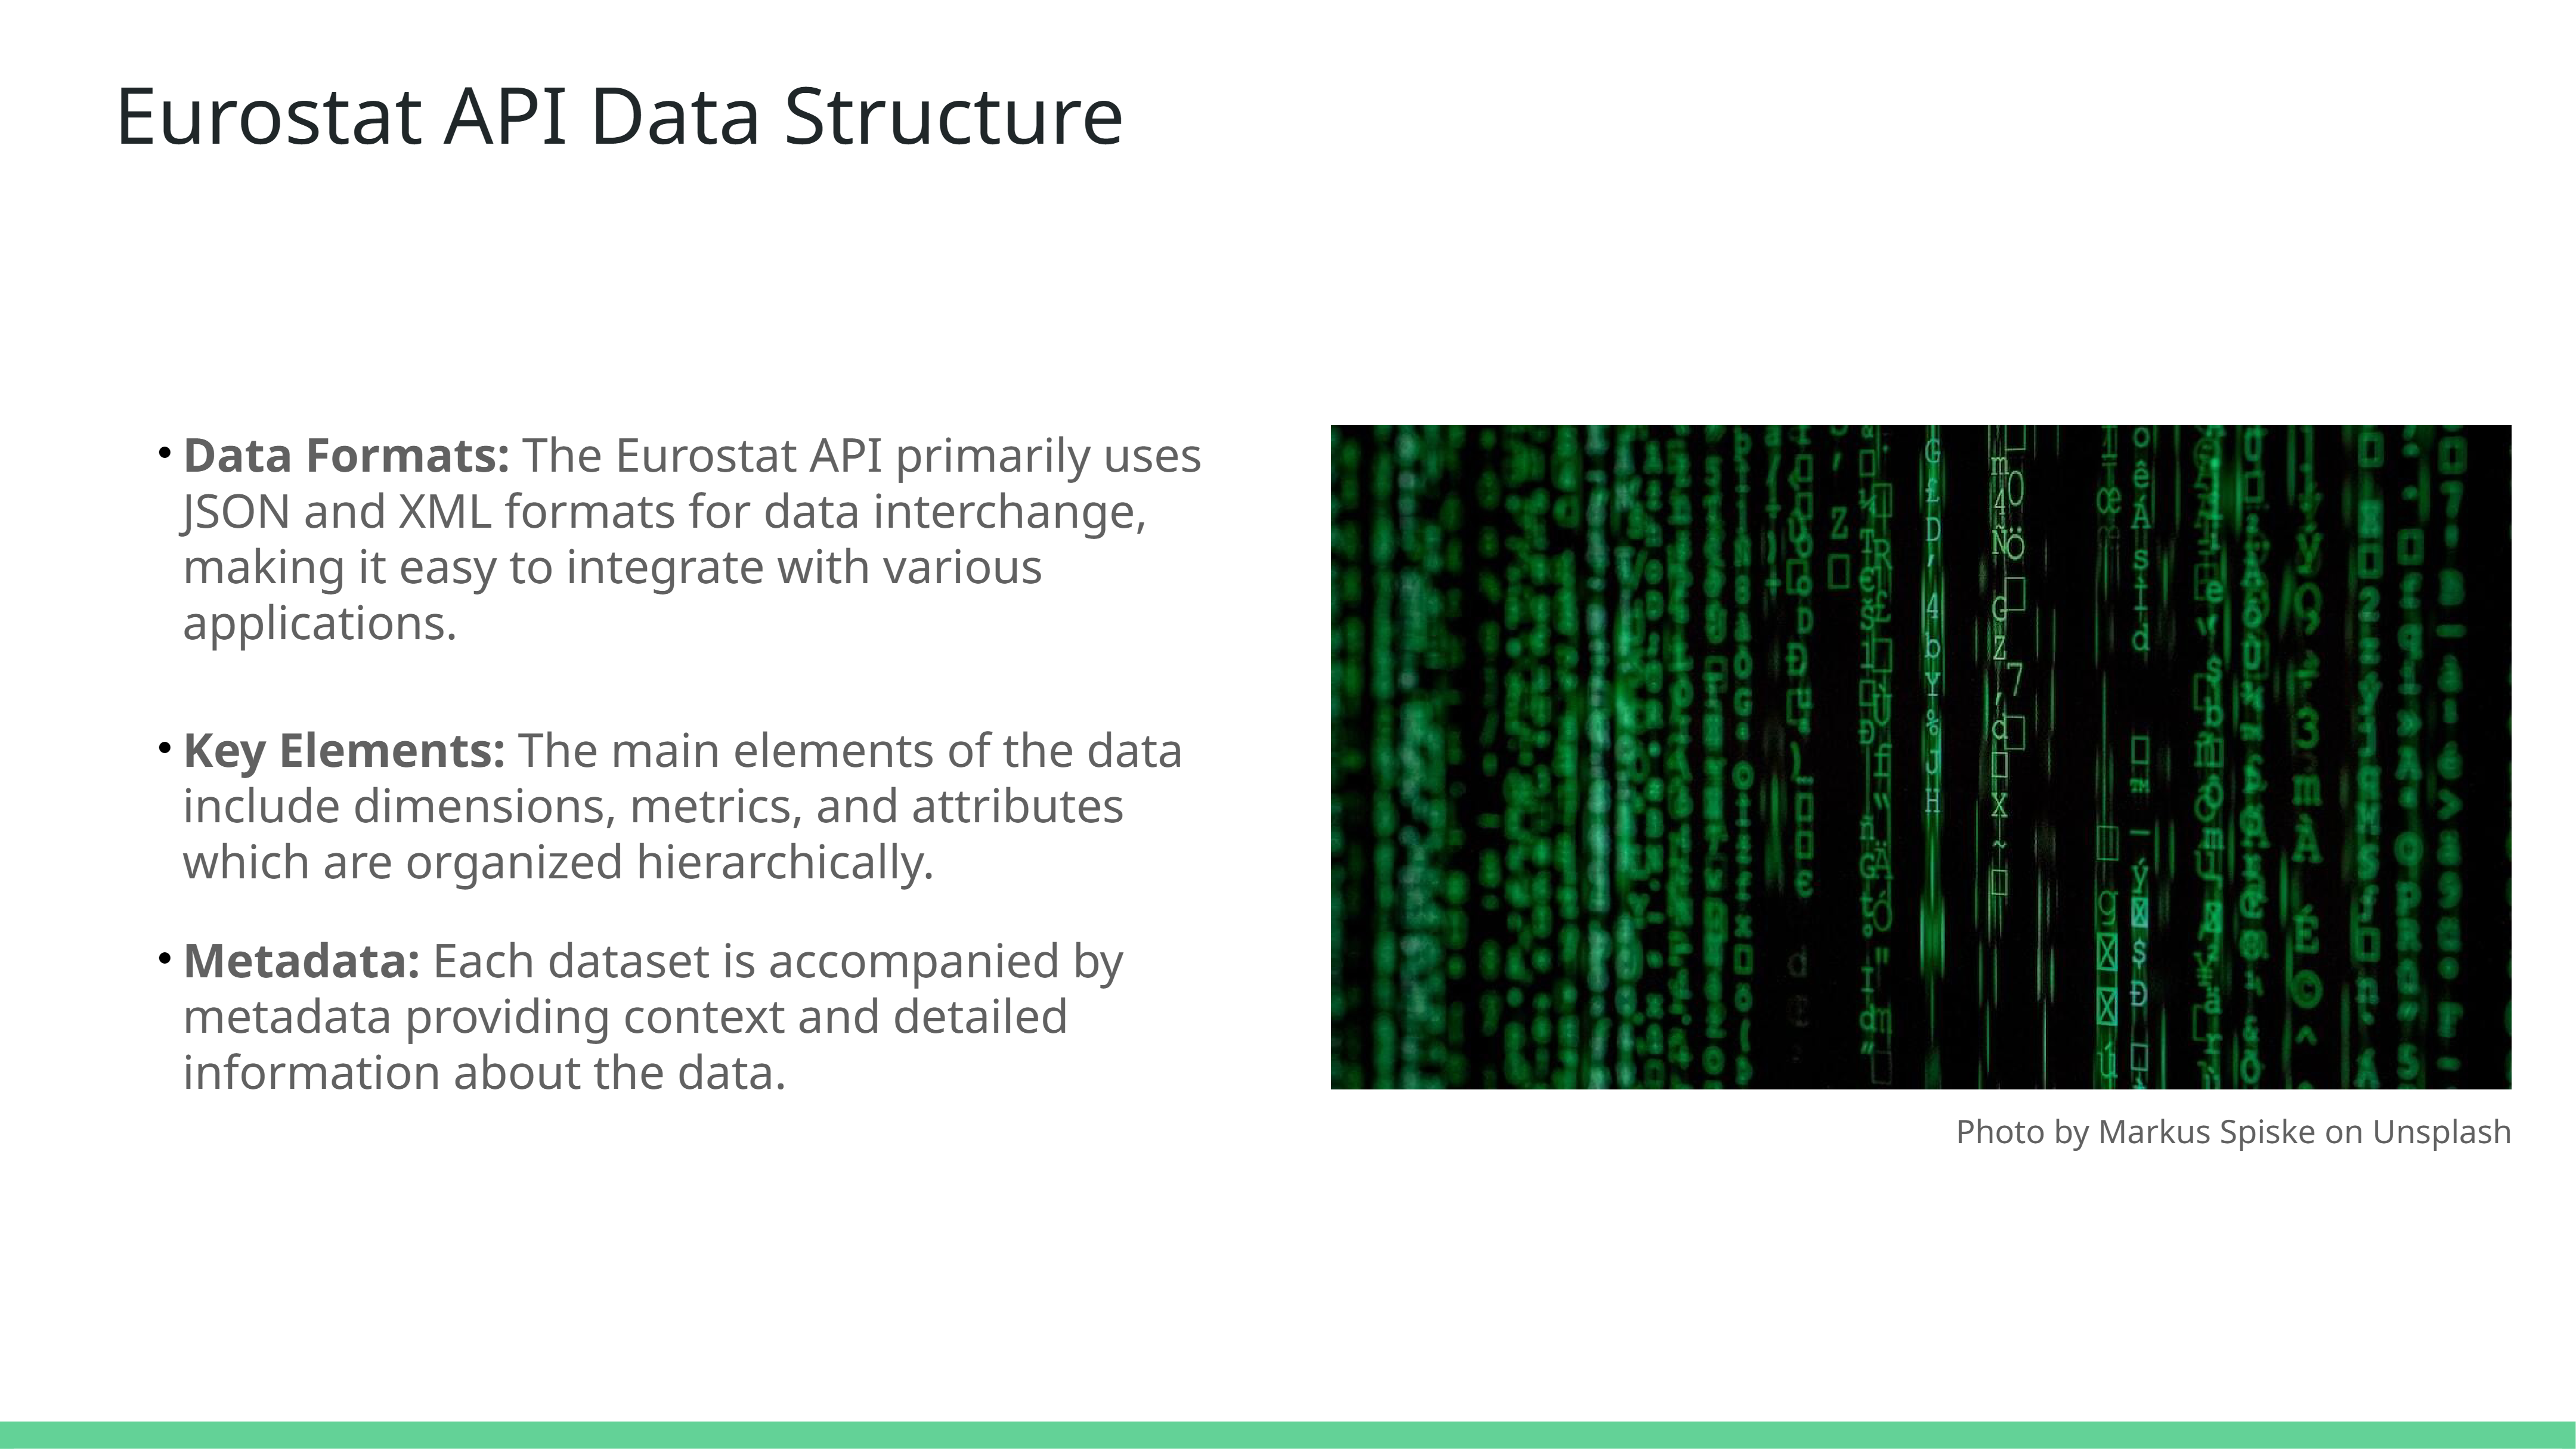

In [2]:
# Define the dataset codes and helper functions
DATASET_CODES = ['nama_10_gdp', 'prc_hicp_midx', 'ert_bil_eur_d']  # Add your dataset codes here

In [3]:
def fetch_updates():
    url = "http://ec.europa.eu/eurostat/api/dissemination/catalogue/dcat/ESTAT/UPDATES"
    try:
        response = requests.get(url)
        response.raise_for_status()
        logging.info(f"Fetched updates successfully. Status code: {response.status_code}")
        return response.text
    except requests.RequestException as e:
        logging.error(f"Error fetching updates: {str(e)}")
        return None

In [4]:
def parse_updates(content):
    updates = {}
    try:
        data = json.loads(content)
        for item in data.get('dataset', []):
            identifier = item.get('identifier')
            modified = item.get('modified')
            if identifier and modified:
                updates[identifier] = modified
    except json.JSONDecodeError:
        lines = content.split('\n')
        for line in lines:
            parts = line.split(',')
            if len(parts) >= 2:
                identifier = parts[0].strip()
                modified = parts[1].strip()
                if identifier and modified:
                    updates[identifier] = modified
    logging.info(f"Parsed updates for {len(updates)} datasets")
    return updates

In [5]:
def download_dataset(dataset_code):
    try:
        logging.info(f"Attempting to download dataset: {dataset_code}")
        eurostat = sdmx.Request('ESTAT')
        data_response = eurostat.data(resource_id=dataset_code)
        df = data_response.to_pandas()
        
        filename = f"{dataset_code}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename)
        logging.info(f"Downloaded {dataset_code} to {filename}")
        return filename
    except Exception as e:
        logging.error(f"Error downloading {dataset_code}: {str(e)}")
        return None

In [6]:
def get_latest_file(dataset_code):
    files = glob.glob(f"{dataset_code}_*.csv")
    if not files:
        logging.info(f"No existing files found for {dataset_code}")
        return None
    latest = max(files, key=os.path.getctime)
    logging.info(f"Latest file for {dataset_code}: {latest}")
    return latest

In [7]:
def process_dataset(dataset_code, updates):
    logging.info(f"Processing dataset: {dataset_code}")
    last_check_file = f"{dataset_code}_last_check.txt"
    
    if os.path.exists(last_check_file):
        with open(last_check_file, 'r') as f:
            last_check = datetime.fromisoformat(f.read().strip())
        logging.info(f"Last check for {dataset_code}: {last_check}")
    else:
        last_check = datetime.min.replace(tzinfo=pytz.UTC)
        logging.info(f"No last check file for {dataset_code}. Using {last_check}")

    latest_file = get_latest_file(dataset_code)
    
    if not latest_file:
        logging.info(f"Dataset {dataset_code} not found. Downloading the latest version.")
        downloaded_file = download_dataset(dataset_code)
        if downloaded_file:
            with open(last_check_file, 'w') as f:
                now = datetime.now(pytz.UTC).isoformat()
                f.write(now)
                logging.info(f"Updated last check for {dataset_code} to {now}")
        return

    modified_date = updates.get(dataset_code)
    if modified_date:
        try:
            modified = datetime.fromisoformat(modified_date)
        except ValueError:
            modified = datetime.strptime(modified_date, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
        logging.info(f"Modified date for {dataset_code}: {modified}")

        file_mtime = datetime.fromtimestamp(os.path.getmtime(latest_file)).replace(tzinfo=pytz.UTC)
        logging.info(f"File mtime for {dataset_code}: {file_mtime}")
        
        if modified > file_mtime:
            logging.info(f"New version available for {dataset_code}")
            download_dataset(dataset_code)
            
            with open(last_check_file, 'w') as f:
                f.write(modified.isoformat())
                logging.info(f"Updated last check for {dataset_code} to {modified.isoformat()}")
        else:
            logging.info(f"No new version for {dataset_code}. Latest file: {latest_file}")
    else:
        logging.warning(f"No update information found for {dataset_code}")

In [ ]:
# Main execution
content = fetch_updates()
if content is not None:
    updates = parse_updates(content)
    for dataset_code in DATASET_CODES:
        process_dataset(dataset_code, updates)
else:
    logging.error("Failed to fetch updates. Exiting.")

In [ ]:
# Display results
for dataset_code in DATASET_CODES:
    latest_file = get_latest_file(dataset_code)
    if latest_file:
        print(f"Latest file for {dataset_code}: {latest_file}")
        # Optionally, you can display the first few rows of the dataset
        df = pd.read_csv(latest_file)
        display(df.head())
    else:
        print(f"No file found for {dataset_code}")

In [ ]:
content = fetch_updates()
if content is not None:
    updates = parse_updates(content)
    print("Available dataset codes:")
    for code in updates.keys():
        print(code)

In [ ]:
def custom_plot(dataset_code):
    latest_file = get_latest_file(dataset_code)
    if latest_file:
        df = pd.read_csv(latest_file)
        plt.figure(figsize=(12, 6))
        # Modify this to create a custom plot
        df.iloc[:, 1:3].plot(kind='bar')
        plt.title(f"Custom Plot for {dataset_code}")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    else:
        print(f"No data available for {dataset_code}")

# Usage
custom_plot(dataset_dropdown.value)

In [ ]:
def custom_analysis(dataset_code):
    latest_file = get_latest_file(dataset_code)
    if latest_file:
        df = pd.read_csv(latest_file)
        print(f"Dataset: {dataset_code}")
        print(f"Number of rows: {df.shape[0]}")
        print(f"Number of columns: {df.shape[1]}")
        print("\nColumn names:")
        print(df.columns.tolist())
        print("\nData types:")
        print(df.dtypes)
        print("\nSummary statistics for numeric columns:")
        print(df.describe())
        # Add more analysis as needed
    else:
        print(f"No data available for {dataset_code}")

# Usage
custom_analysis(dataset_dropdown.value)

In [ ]:
# Cell 1: Import libraries and set up logging
import requests
import pandas as pd
import pandasdmx as sdmx
from datetime import datetime
import pytz
import os
import json
import glob
import logging
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, HTML
from tqdm.notebook import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Cell 2: Define helper functions

def fetch_updates():
    """Fetch updates from Eurostat API."""
    url = "http://ec.europa.eu/eurostat/api/dissemination/catalogue/dcat/ESTAT/UPDATES"
    try:
        response = requests.get(url)
        response.raise_for_status()
        logging.info(f"Fetched updates successfully. Status code: {response.status_code}")
        return response.text
    except requests.RequestException as e:
        logging.error(f"Error fetching updates: {str(e)}")
        return None

def parse_updates(content):
    """Parse the updates content."""
    updates = {}
    try:
        data = json.loads(content)
        for item in data.get('dataset', []):
            identifier = item.get('identifier')
            modified = item.get('modified')
            if identifier and modified:
                updates[identifier] = modified
    except json.JSONDecodeError:
        lines = content.split('\n')
        for line in lines:
            parts = line.split(',')
            if len(parts) >= 2:
                identifier = parts[0].strip()
                modified = parts[1].strip()
                if identifier and modified:
                    updates[identifier] = modified
    logging.info(f"Parsed updates for {len(updates)} datasets")
    return updates

def download_dataset(dataset_code):
    """Download a dataset from Eurostat."""
    try:
        logging.info(f"Attempting to download dataset: {dataset_code}")
        eurostat = sdmx.Request('ESTAT')
        data_response = eurostat.data(resource_id=dataset_code)
        df = data_response.to_pandas()
        
        filename = f"{dataset_code}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename)
        logging.info(f"Downloaded {dataset_code} to {filename}")
        return filename
    except Exception as e:
        logging.error(f"Error downloading {dataset_code}: {str(e)}")
        return None

def get_latest_file(dataset_code):
    """Get the latest file for a given dataset code."""
    files = glob.glob(f"{dataset_code}_*.csv")
    if not files:
        logging.info(f"No existing files found for {dataset_code}")
        return None
    latest = max(files, key=os.path.getctime)
    logging.info(f"Latest file for {dataset_code}: {latest}")
    return latest

def process_dataset(dataset_code, updates):
    """Process a single dataset."""
    logging.info(f"Processing dataset: {dataset_code}")
    last_check_file = f"{dataset_code}_last_check.txt"
    
    if os.path.exists(last_check_file):
        with open(last_check_file, 'r') as f:
            last_check = datetime.fromisoformat(f.read().strip())
        logging.info(f"Last check for {dataset_code}: {last_check}")
    else:
        last_check = datetime.min.replace(tzinfo=pytz.UTC)
        logging.info(f"No last check file for {dataset_code}. Using {last_check}")

    latest_file = get_latest_file(dataset_code)
    
    if not latest_file:
        logging.info(f"Dataset {dataset_code} not found. Downloading the latest version.")
        downloaded_file = download_dataset(dataset_code)
        if downloaded_file:
            with open(last_check_file, 'w') as f:
                now = datetime.now(pytz.UTC).isoformat()
                f.write(now)
                logging.info(f"Updated last check for {dataset_code} to {now}")
        return

    modified_date = updates.get(dataset_code)
    if modified_date:
        try:
            modified = datetime.fromisoformat(modified_date)
        except ValueError:
            modified = datetime.strptime(modified_date, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
        logging.info(f"Modified date for {dataset_code}: {modified}")

        file_mtime = datetime.fromtimestamp(os.path.getmtime(latest_file)).replace(tzinfo=pytz.UTC)
        logging.info(f"File mtime for {dataset_code}: {file_mtime}")
        
        if modified > file_mtime:
            logging.info(f"New version available for {dataset_code}")
            download_dataset(dataset_code)
            
            with open(last_check_file, 'w') as f:
                f.write(modified.isoformat())
                logging.info(f"Updated last check for {dataset_code} to {modified.isoformat()}")
        else:
            logging.info(f"No new version for {dataset_code}. Latest file: {latest_file}")
    else:
        logging.warning(f"No update information found for {dataset_code}")

def plot_dataset(dataset_code):
    """Plot a simple visualization of the dataset."""
    latest_file = get_latest_file(dataset_code)
    if latest_file:
        df = pd.read_csv(latest_file)
        plt.figure(figsize=(10, 6))
        df.iloc[:, 1].plot(title=f"Sample Plot for {dataset_code}")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.show()
    else:
        print(f"No data available for {dataset_code}")

# Cell 3: Create interactive widgets
dataset_dropdown = widgets.Dropdown(
    options=[],
    description='Dataset:',
    disabled=False,
)

update_button = widgets.Button(
    description='Update Dataset',
    disabled=False,
    button_style='', 
    tooltip='Click to update the selected dataset',
    icon='check'
)

output = widgets.Output()

# Cell 4: Define update function
def on_update_button_clicked(b):
    with output:
        output.clear_output()
        dataset_code = dataset_dropdown.value
        print(f"Updating dataset: {dataset_code}")
        content = fetch_updates()
        if content is not None:
            updates = parse_updates(content)
            process_dataset(dataset_code, updates)
            plot_dataset(dataset_code)
        else:
            print("Failed to fetch updates.")

update_button.on_click(on_update_button_clicked)

# Cell 5: Display widgets
display(dataset_dropdown, update_button, output)

# Cell 6: Initialize dataset list
content = fetch_updates()
if content is not None:
    updates = parse_updates(content)
    dataset_dropdown.options = list(updates.keys())
else:
    print("Failed to fetch initial dataset list.")

# Cell 7: Example data analysis
def analyze_dataset(dataset_code):
    latest_file = get_latest_file(dataset_code)
    if latest_file:
        df = pd.read_csv(latest_file)
        print(f"Dataset shape: {df.shape}")
        print("\nFirst few rows:")
        display(df.head())
        print("\nBasic statistics:")
        display(df.describe())
        print("\nMissing values:")
        display(df.isnull().sum())
    else:
        print(f"No data available for {dataset_code}")

# Usage: analyze_dataset(dataset_dropdown.value)

# Cell 8: Metadata exploration
def explore_metadata(dataset_code):
    try:
        eurostat = sdmx.Request('ESTAT')
        metadata = eurostat.datastructure(dataset_code)
        print(f"Metadata for {dataset_code}:")
        print(metadata)
    except Exception as e:
        print(f"Error fetching metadata for {dataset_code}: {str(e)}")

# Usage: explore_metadata(dataset_dropdown.value)

In [ ]:
import requests
import pandas as pd
import pandasdmx as sdmx
from datetime import datetime
import pytz
import os
import json
import time
import glob

# List of dataset codes you're interested in
DATASET_CODES = ['nama_10_gdp', 'prc_hicp_midx', 'ert_bil_eur_d']  # Add your dataset codes here

def fetch_updates():
    url = "http://ec.europa.eu/eurostat/api/dissemination/catalogue/dcat/ESTAT/UPDATES"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        return response.text
    except requests.RequestException as e:
        print(f"Error fetching updates: {str(e)}")
        return None

def parse_updates(content):
    updates = {}
    try:
        # Attempt to parse as JSON
        data = json.loads(content)
        for item in data.get('dataset', []):
            identifier = item.get('identifier')
            modified = item.get('modified')
            if identifier and modified:
                updates[identifier] = modified
    except json.JSONDecodeError:
        # If not JSON, attempt to parse as simple text
        lines = content.split('\n')
        for line in lines:
            parts = line.split(',')
            if len(parts) >= 2:
                identifier = parts[0].strip()
                modified = parts[1].strip()
                if identifier and modified:
                    updates[identifier] = modified
    return updates

def download_dataset(dataset_code):
    try:
        eurostat = sdmx.Request('ESTAT')
        data_response = eurostat.data(resource_id=dataset_code)
        df = data_response.to_pandas()
        
        filename = f"{dataset_code}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename)
        print(f"Downloaded {dataset_code} to {filename}")
        return filename
    except Exception as e:
        print(f"Error downloading {dataset_code}: {str(e)}")
        return None

def get_latest_file(dataset_code):
    files = glob.glob(f"{dataset_code}_*.csv")
    if not files:
        return None
    return max(files, key=os.path.getctime)

def main():
    content = fetch_updates()
    if content is None:
        return

    updates = parse_updates(content)

    for dataset_code in DATASET_CODES:
        last_check_file = f"{dataset_code}_last_check.txt"
        
        if os.path.exists(last_check_file):
            with open(last_check_file, 'r') as f:
                last_check = datetime.fromisoformat(f.read().strip())
        else:
            last_check = datetime.min.replace(tzinfo=pytz.UTC)

        latest_file = get_latest_file(dataset_code)
        
        if not latest_file:
            print(f"Dataset {dataset_code} not found. Downloading the latest version.")
            downloaded_file = download_dataset(dataset_code)
            if downloaded_file:
                with open(last_check_file, 'w') as f:
                    f.write(datetime.now(pytz.UTC).isoformat())
            continue

        modified_date = updates.get(dataset_code)
        if modified_date:
            try:
                modified = datetime.fromisoformat(modified_date)
            except ValueError:
                modified = datetime.strptime(modified_date, "%Y-%m-%d").replace(tzinfo=pytz.UTC)

            file_mtime = datetime.fromtimestamp(os.path.getmtime(latest_file)).replace(tzinfo=pytz.UTC)
            
            if modified > file_mtime:
                print(f"New version available for {dataset_code}")
                download_dataset(dataset_code)
                
                with open(last_check_file, 'w') as f:
                    f.write(modified.isoformat())
            else:
                print(f"No new version for {dataset_code}. Latest file: {latest_file}")
        else:
            print(f"No update information found for {dataset_code}")

if __name__ == "__main__":
    main()
    time.sleep(5)  # Add a delay to keep the console window open

In [19]:
import asyncio
import aiohttp
import pandas as pd
import pandasdmx as sdmx
from datetime import datetime
import pytz
import os
import json
import glob
import logging
import pickle
from IPython.display import display
from chardet import detect


# Cell 1: Asynchronous functions for API requests


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

async def fetch_updates_async():
    """Fetch updates from Eurostat API asynchronously."""
    url = "http://ec.europa.eu/eurostat/api/dissemination/catalogue/dcat/ESTAT/UPDATES"
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            if response.status == 200:
                content = await response.read()
                encoding = detect(content)['encoding']
                if encoding is None:
                    encoding = 'iso-8859-1'  # fallback to a common encoding
                return content.decode(encoding)
            else:
                logging.error(f"Error fetching updates: {response.status}")
                return None

def parse_updates(content):
    """Parse the updates content."""
    updates = {}
    try:
        data = json.loads(content)
        for item in data.get('dataset', []):
            identifier = item.get('identifier')
            modified = item.get('modified')
            if identifier and modified:
                updates[identifier] = modified
    except json.JSONDecodeError:
        lines = content.split('\n')
        for line in lines:
            parts = line.split(',')
            if len(parts) >= 2:
                identifier = parts[0].strip()
                modified = parts[1].strip()
                if identifier and modified:
                    updates[identifier] = modified
    logging.info(f"Parsed updates for {len(updates)} datasets")
    return updates

# Cell 2: Improved download function with streaming and caching

async def download_dataset_async(dataset_code, session):
    """Download a dataset from Eurostat asynchronously."""
    cache_file = f"{dataset_code}_cache.pkl"
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    try:
        logging.info(f"Attempting to download dataset: {dataset_code}")
        eurostat = sdmx.Request('ESTAT')
        data_response = await asyncio.to_thread(eurostat.data, resource_id=dataset_code)
        df = data_response.to_pandas()
        
        filename = f"{dataset_code}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename)
        logging.info(f"Downloaded {dataset_code} to {filename}")

        with open(cache_file, 'wb') as f:
            pickle.dump(df, f)

        return df
    except Exception as e:
        logging.error(f"Error downloading {dataset_code}: {str(e)}")
        return None

# Cell 3: Helper functions

def get_latest_file(dataset_code):
    """Get the latest file for a given dataset code."""
    files = glob.glob(f"{dataset_code}_*.csv")
    if not files:
        logging.info(f"No existing files found for {dataset_code}")
        return None
    latest = max(files, key=os.path.getctime)
    logging.info(f"Latest file for {dataset_code}: {latest}")
    return latest

async def process_dataset_async(dataset_code, updates, session):
    """Process a single dataset asynchronously."""
    logging.info(f"Processing dataset: {dataset_code}")
    last_check_file = f"{dataset_code}_last_check.txt"
    
    if os.path.exists(last_check_file):
        with open(last_check_file, 'r') as f:
            last_check = datetime.fromisoformat(f.read().strip())
        logging.info(f"Last check for {dataset_code}: {last_check}")
    else:
        last_check = datetime.min.replace(tzinfo=pytz.UTC)
        logging.info(f"No last check file for {dataset_code}. Using {last_check}")

    latest_file = get_latest_file(dataset_code)
    
    modified_date = updates.get(dataset_code)
    if modified_date:
        try:
            modified = datetime.fromisoformat(modified_date)
        except ValueError:
            modified = datetime.strptime(modified_date, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
        logging.info(f"Modified date for {dataset_code}: {modified}")

        if not latest_file or modified > datetime.fromtimestamp(os.path.getmtime(latest_file)).replace(tzinfo=pytz.UTC):
            logging.info(f"New version available for {dataset_code}")
            df = await download_dataset_async(dataset_code, session)
            if df is not None:
                with open(last_check_file, 'w') as f:
                    f.write(modified.isoformat())
                    logging.info(f"Updated last check for {dataset_code} to {modified.isoformat()}")
            return df
        else:
            logging.info(f"No new version for {dataset_code}. Latest file: {latest_file}")
    else:
        logging.warning(f"No update information found for {dataset_code}")
    
    return None

# Cell 4: Main execution function

async def main_async(dataset_codes):
    content = await fetch_updates_async()
    if content is not None:
        updates = parse_updates(content)
        async with aiohttp.ClientSession() as session:
            tasks = [process_dataset_async(code, updates, session) for code in dataset_codes]
            results = await asyncio.gather(*tasks)
        
        return {code: df for code, df in zip(dataset_codes, results) if df is not None}
    else:
        logging.error("Failed to fetch updates. Exiting.")
        return {}

# Cell 5: Run the asynchronous main function

DATASET_CODES = ['nama_10_gdp', 'prc_hicp_midx', 'ert_bil_eur_d']  # Add your dataset codes here

# Use this function to run the async code
async def run_async():
    results = await main_async(DATASET_CODES)
    return results

# Cell 6: Execute and display results



In [20]:
# Run this cell to execute the async code and get results
results = await run_async()


2024-06-27 04:32:05,731 - INFO - Parsed updates for 546 datasets
2024-06-27 04:32:05,732 - INFO - Processing dataset: nama_10_gdp
2024-06-27 04:32:05,737 - INFO - Last check for nama_10_gdp: 2024-06-27 02:14:56.348761+00:00
2024-06-27 04:32:05,738 - INFO - Latest file for nama_10_gdp: nama_10_gdp_20240627_041454.csv
2024-06-27 04:32:05,739 - WARNING - No update information found for nama_10_gdp
2024-06-27 04:32:05,739 - INFO - Processing dataset: prc_hicp_midx
2024-06-27 04:32:05,740 - INFO - No last check file for prc_hicp_midx. Using 0001-01-01 00:00:00+00:00
2024-06-27 04:32:05,741 - INFO - No existing files found for prc_hicp_midx
2024-06-27 04:32:05,741 - WARNING - No update information found for prc_hicp_midx
2024-06-27 04:32:05,742 - INFO - Processing dataset: ert_bil_eur_d
2024-06-27 04:32:05,743 - INFO - No last check file for ert_bil_eur_d. Using 0001-01-01 00:00:00+00:00
2024-06-27 04:32:05,744 - INFO - No existing files found for ert_bil_eur_d
2024-06-27 04:32:05,744 - WARN

In [21]:
# Display results
for dataset_code, df in results.items():
    print(f"Dataset: {dataset_code}")
    display(df.head())
    print("\n")